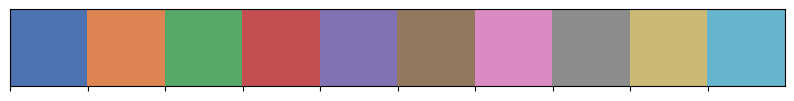

In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch_scatter
from tqdm import tqdm

import optbayesexpt as obe
import config_matplotlib
import seaborn as sns
from src.utils_general import prepare_sample

cmap_global = sns.color_palette('deep')
sns.palplot(cmap_global)

In [2]:
def read_pkl_data(fname):
    with open(fname, 'rb') as f:
        data_dict = pickle.load(f)
    loss_abs = np.abs(data_dict['param_mean'] - data_dict['param_true'][:,None,:])
    loss_rel = (np.abs(data_dict['param_mean'] - data_dict['param_true'][:,None,:])) / np.abs(data_dict['param_true'][:,None,:])
    return loss_abs, loss_rel

In [3]:
def read_pkl_data_for_dict(fname):
    with open(fname, 'rb') as f:
        data_dict = pickle.load(f)
    param_mean_raw = []
    param_true = []
    measured_settings = []
    measured_values = []
    for idx in data_dict.keys():
        # param_mean_raw.append(data_dict[idx]['param_mean'][None])
        param_mean_raw.append((data_dict[idx]['particles'] * data_dict[idx]['particle_weights'][:,None,:]).sum(axis=-1)[None])
        param_true.append(data_dict[idx]['param_true'][None])
        measured_settings.append(data_dict[idx]['measurement_settings'])
        measured_values.append(data_dict[idx]['measurements'])
    max_len = max([p.shape[1] for p in param_mean_raw])
    param_mean = []
    for p in param_mean_raw:
        if p.shape[0] < max_len:
            param_mean.append(np.concatenate([p, np.repeat(p[:,-1,None,:], max_len-p.shape[1], axis=1)], axis=1))
        else:
            param_mean.append(p)
    param_mean = np.vstack(param_mean)
    param_true = np.vstack(param_true)
    loss_abs = np.abs(param_mean - param_true[:,None,:])
    loss_rel = (np.abs(param_mean - param_true[:,None,:])) / np.abs(param_true[:,None,:])

    # loss_abs = np.abs(data_dict['param_mean'] - data_dict['param_true'][:,None,:])
    # loss_rel = (np.abs(data_dict['param_mean'] - data_dict['param_true'][:,None,:])) / np.abs(data_dict['param_true'][:,None,:])
    return loss_abs, loss_rel, param_true, measured_settings, measured_values

In [4]:
Nb = 40
noise_level_list = [0.5, 1.0, 2.0]
pw_list = [0.1, 0.2]
datadir = 'benchmarks_2023May01'
task_labels = ['gd', 'baseline', 'sequential', 'random']
run_labels = [f'RUN_{i+1}' for i in range(5)]
scatter_mean_indices = torch.arange(len(task_labels)).repeat_interleave(len(run_labels))
print(scatter_mean_indices)

results = {}

tensor([0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3])


In [5]:
times = np.linspace(0, 3, 121)
times_finer = np.linspace(0, 3, 601)
data = torch.load("data/CrI3/20221110.pt")
X = data['param'][:,:2]
Y = torch.cat((data['omega'], data['inten']), dim=1)

indices_dict = torch.load("data_splitting/indices_42_800-100-100.pt")
test_indices = indices_dict['test']

X_test = X[test_indices]
Y_test = Y[test_indices]

In [6]:
for pw in tqdm(pw_list):
    for nl in noise_level_list:
        fname_lst = [
            os.path.join(datadir, f'{run}/bayesian_{task}_pw-{pw}_nl-{nl}_Nb-{Nb:d}.pkl') for task in task_labels for run in run_labels
        ]
        # print('\n'.join(fname_lst))
        # loss_abs = [read_pkl_data_for_dict(f)[0] for f in fname_lst]
        loss_abs = []
        param_true = []
        measured_settings = []
        measured_values = []
        for f in fname_lst:
            _loss_abs, _loss_rel, _param_true, _settings, _values = read_pkl_data_for_dict(f)
            loss_abs.append(_loss_abs)
            param_true.append(_param_true)
            measured_settings.append(_settings)
            measured_values.append(_values)
        # loss_rel = [read_pkl_data_for_dict(f)[1] for f in fname_lst]
        loss = torch.tensor(np.asarray(loss_abs))
        param_true = torch.tensor(np.asarray(param_true))
        loss_exp_mean = torch_scatter.scatter_mean(loss, scatter_mean_indices, dim=0)
        loss_mean = loss_exp_mean.mean(dim=1)
        loss_std = torch_scatter.scatter_std(loss, scatter_mean_indices, dim=0).mean(dim=1)

        signals = np.zeros((20, 100, len(times)))
        signals_finer = np.zeros((20, 100, len(times_finer)))
        for i_sample in tqdm(range(len(X_test))):
            x = X_test[i_sample]
            y = Y_test[i_sample]
            for i_r, result in enumerate(param_true[:,i_sample,:]):
                _, _, gamma, amp, wid = result
                amp_factor = (amp / y[2:].max()).item()
                _, func_I_conv, func_I_noconv = prepare_sample(
                    x, y, gamma, times_finer, pulse_width=pw, normalize_to_value=100, 
                    elas_amp_factor=amp_factor, elas_wid=wid, elas_amp_abs_max=10.)
                signals[i_r, i_sample] = func_I_conv(times)
                signals_finer[i_r, i_sample] = func_I_conv(times_finer)

        results[(pw, nl)] = {
            "mean_loss_avg_over_runs_samples": loss_mean,
            "std_loss_avg_over_runs_samples": loss_std,
            "loss_avg_over_runs": loss_exp_mean,
            "loss_full": loss,
            "loss_indices": scatter_mean_indices,
            "param_true": param_true,
            "times": torch.from_numpy(times),
            "signals": torch.from_numpy(signals),
            "measured_settings": measured_settings,
            "measured_values": measured_values,
            "times_finer": torch.from_numpy(times_finer),
            "signals_finer": torch.from_numpy(signals_finer),
        }
torch.save(results, f"{datadir}/summarized_results.pt")

  0%|          | 0/2 [00:00<?, ?it/s]/tmp/ipykernel_50897/3009307654.py:24: RuntimeWarning: divide by zero encountered in divide
  loss_rel = (np.abs(param_mean - param_true[:,None,:])) / np.abs(param_true[:,None,:])
/home/zhantao/Dropbox/SLAC/research/TopologicalSpinML/topo-spin-Sqt-ML-main/src/utils_convolution.py:19: NumbaExperimentalFeatureWarning: Use of isinstance() detected. This is an experimental feature.
  if isinstance(t, (int, float)):
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.
100%|██████████| 100/100 [01:19<00:00,  1.26it/s]
/tmp/ipykernel_50897/3009307654.py:24: RuntimeWarning: divide by zero encountered in divide
  loss_rel = (np.abs(param_mean - param_true[:,None,:])) / np.abs(param_true[:,None,:])
100%|██████████| 2/2 [07:23<00:00, 221.80s/it]


In [7]:
[np.mean(results[(0.1,0.5)]['loss_avg_over_runs'][i_strat,:,-1,0].numpy()) for i_strat in range(4)]

[0.12079443, 0.1671994, 0.16999525, 0.28774175]

In [8]:
results[(0.1,0.5)]['loss_avg_over_runs'].mean(dim=1)[:,-1,:2]

tensor([[0.1208, 0.0682],
        [0.1672, 0.1002],
        [0.1700, 0.0954],
        [0.2877, 0.1638]])